In [ ]:
# Define the ansatz
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
file=open('/home/shyam/Code_mixed/fb_hi_cg_train2.txt','r')
sentence=[]
tag=[]
data=[]
for line in file:
    words=line.split()
    if len(line) > 1 and not line.startswith('.'):
        sentence.append(words[0])
        tag.append(words[-1])
    else:
        if sentence:  # Ensure we only add if sentence is not empty
            temp = []
            temp.append(sentence)
            temp.append(tag)
            data.append(temp)
        sentence=[]
        tag=[]

In [ ]:
# Special tokens
word2idx = {"<PAD>": 0}  # Unknown & Padding tokens
tag2idx = {"<PAD>": 0}  # For POS tags

idx2word = {0: "<PAD>"}  # Reverse mapping for decoding
idx2tag = {0: "<PAD>"}  # Reverse mapping for tags

# Build vocabulary from the dataset
for sentence, tags in data:
    for word in sentence:
        if word not in word2idx:
            new_idx = len(word2idx)  # New index for the word
            word2idx[word] = new_idx
            idx2word[new_idx] = word  # Add to reverse mapping
    for tag in tags:
        if tag not in tag2idx:
            new_idx = len(tag2idx)  # New index for the tag
            tag2idx[tag] = new_idx
            idx2tag[new_idx] = tag  # Add to reverse mapping


In [ ]:
sentence_lengths = [len(words) for words, tags in data]

/home/shyam/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


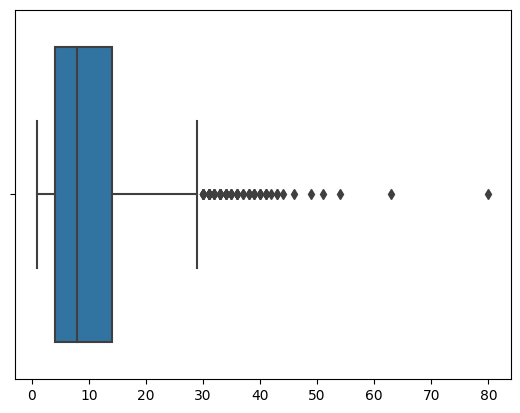

In [ ]:
sns.boxplot(sentence_lengths)
plt.show()

In [ ]:
# Convert Data to Indices
def encode_data(data, word_vocab, tag_vocab):
    encoded_sentences = []
    encoded_tags = []
    for sentence, tags in data:
        encoded_sentence = [word_vocab[word] for word in sentence]
        encoded_tags.append([tag_vocab[tag] for tag in tags])
        encoded_sentences.append(encoded_sentence)
    return encoded_sentences, encoded_tags

X,Y = encode_data(data, word2idx, tag2idx)

In [ ]:
X,Y

([[1, 2, 3],
  [4, 5, 6, 7, 8, 9],
  [10, 11, 12, 13, 14, 15],
  [16, 17, 18, 6, 19, 20, 21, 22, 23, 24, 25, 26, 22, 27, 28, 29, 30, 31, 32],
  [33, 34, 35],
  [36],
  [37, 38, 39, 40, 41, 42, 43, 44, 45, 7],
  [46,
   47,
   16,
   17,
   18,
   6,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   22,
   27,
   28,
   29,
   30,
   31,
   32],
  [48, 49, 50, 51, 52, 53, 54, 55, 35, 56, 57, 42, 58, 59, 60],
  [61, 62, 63, 7, 64, 65, 66],
  [67, 68, 69, 42, 70],
  [71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
  [81, 7, 82, 83, 84, 85],
  [86, 87, 88],
  [89],
  [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
  [86, 100, 101, 102, 103, 104, 105, 106, 99, 107, 91, 108, 109, 110],
  [111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   123,
   126,
   123,
   127,
   128,
   123,
   129],
  [130,
   129,
   131,
   116,
   132,
   133,
   134,
   135,
   136,
   33,
   137,
   138,
   139,
   140,
   141,
   114,
   136,
   

In [ ]:
# Pad or Truncate Sequences
def pad_or_truncate_sequences(sequences, pad_value, max_len=10):
    result = []
    for seq in sequences:
        if len(seq) > max_len:  # Truncate sequences longer than max_len
            result.append(seq[:max_len])
        else:  # Pad sequences shorter than max_len
            result.append(seq + [pad_value] * (max_len - len(seq)))
    return result

# Pad or Truncate Sentences and Tags
padded_sentences = pad_or_truncate_sequences(X, pad_value=word2idx["<PAD>"], max_len=10)
padded_tags = pad_or_truncate_sequences(Y, pad_value=0, max_len=10)  # -1 for padding tags

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sentences, padded_tags, test_size=0.30, random_state=42)

In [ ]:
X_train, y_train

([[2667, 3982, 33, 1535, 51, 347, 1151, 0, 0, 0],
  [20, 3971, 1219, 1282, 759, 2835, 1608, 33, 2261, 27],
  [1023, 1582, 33, 1583, 84, 1584, 44, 1524, 558, 1585],
  [24, 1001, 1524, 3067, 44, 1299, 1328, 35, 558, 397],
  [2199, 99, 0, 0, 0, 0, 0, 0, 0, 0],
  [12, 3242, 0, 0, 0, 0, 0, 0, 0, 0],
  [4005, 35, 1671, 51, 33, 1531, 17, 2142, 51, 80],
  [2861, 44, 3413, 773, 3420, 84, 3421, 52, 33, 177],
  [136, 2575, 1189, 324, 17, 2353, 35, 1158, 44, 1278],
  [44, 25, 3231, 3232, 565, 1174, 1282, 193, 1158, 96],
  [157, 1272, 2188, 1084, 2961, 0, 0, 0, 0, 0],
  [628, 606, 103, 606, 0, 0, 0, 0, 0, 0],
  [4032, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [2933, 2934, 2935, 25, 2189, 24, 1224, 1817, 783, 256],
  [1166, 1328, 2059, 630, 0, 0, 0, 0, 0, 0],
  [528, 582, 2031, 2032, 17, 2033, 174, 0, 0, 0],
  [422, 423, 201, 424, 425, 352, 272, 392, 426, 88],
  [434, 3396, 3397, 44, 3126, 35, 1437, 3398, 51, 44],
  [4674, 4675, 607, 936, 15, 99, 0, 0, 0, 0],
  [1668, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [44, 1193, 0,

In [ ]:
def load_word_embeddings(file_path):
    word_to_embedding = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            word = parts[0]
            embedding = np.array(parts[1:], dtype=np.float32)
            word_to_embedding[word] = embedding
    word_to_embedding['<PAD>'] = np.zeros(100, dtype=np.float32)
    return word_to_embedding

# Path to your file
file_path = "/home/shyam/Downloads/wordVectors100.txt"

# Load embeddings with fixed dimension (e.g., 100 based on your sample)
embedding_matrix = load_word_embeddings(file_path)

In [ ]:
word_to_embedding = load_word_embeddings(file_path)

# Prepare data for PCA
words = list(word_to_embedding.keys())  # Ensure correct dictionary reference
embeddings_100d = np.array(list(word_to_embedding.values()))  # Shape: [num_words, 100]
print("Original embedding shape:", embeddings_100d.shape)

# Apply PCA to reduce to 12 dimensions
pca = PCA(n_components=12)  # Target 12 dimensions
embeddings_12d = pca.fit_transform(embeddings_100d)  # Shape: [num_words, 12]

# Explained variance (how much information is retained)
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each component:", explained_variance_ratio)
print("Total variance retained:", sum(explained_variance_ratio))
print("Reduced embedding shape:", embeddings_12d.shape)

# Create new dictionary with 12D embeddings
word_to_embedding_12d = {word: embeddings_12d[i] for i, word in enumerate(words)}

Original embedding shape: (95495, 100)
Explained variance ratio for each component: [0.13355415 0.07881733 0.05090143 0.04840604 0.04251125 0.02979425
 0.02712057 0.02696553 0.02027588 0.01913615 0.0175619  0.01428304]
Total variance retained: 0.5093274985804493
Reduced embedding shape: (95495, 12)


In [ ]:
num_tags = len(idx2tag)  # 12

# Create one-hot vectors matrix
y_one_hot = np.zeros((num_tags, num_tags), dtype=int)  # Shape: [12, 12]

# Populate with one-hot encodings
for idx in range(num_tags):
    y_one_hot[idx, idx] = 1  # Set 1 at the index position

In [ ]:
def word2vec(x):
    word2vec = np.array([word_to_embedding_12d[idx2word[i]] for i in x])
    return word2vec

In [ ]:
def categorical_cross_entropy(y_true, y_pred):
    epsilon = 1e-9  # To prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip probabilities
    loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))  # Sum over classes, then mean
    return loss

In [ ]:
num_data_wires = 12  # Number of data wires
num_ancilla_wires = 4  # Number of ancilla wires

data_wires = list(range(num_data_wires))  # Generates [0, 1, 2, 3]
ancilla_wires = list(range(num_data_wires, num_data_wires + num_ancilla_wires))  # Generates [4, 5]
wires=data_wires+ancilla_wires
print("Data wires:", data_wires)
print("Ancilla wires:", ancilla_wires)
dev = qml.device("lightning.qubit", wires=wires,shots=1)

Data wires: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Ancilla wires: [12, 13, 14, 15]


In [ ]:
def ansatz(x, params):

    mcms = []

    # Apply RX rotations based on input features
    for wire, sample in zip(data_wires, x):
        qml.RX(sample, wires=wire)

    # Apply RY rotations based on trainable parameters
    for wire, param in zip(wires, params):
        qml.RY(param, wires=wire)

    # Apply CNOT gates between ancilla and data wires
#     for ancilla in ancilla_wires:
#         for data in data_wires:
#             qml.CNOT(wires=[ancilla, data])
    for w in range(len(wires) - 1):
        qml.CNOT(wires=[wires[w], wires[w + 1]])

    # Add CNOT between the last qubit and the first qubit
    qml.CNOT(wires=[wires[-1], wires[0]])

    # Mid-circuit measurements with reset
    mcms = [qml.measure(w, reset=True) for w in data_wires]

    return mcms


In [ ]:
@qml.qnode(dev)
def simple_node_single(x, params):
    outputs=[]
    for sample in x:
        output=ansatz(sample, params)
        outputs.append(output)
    return [qml.expval(o) for output in outputs for o in output]

In [ ]:
from pennylane import numpy as np
params= np.random.rand(16)

In [ ]:
params

tensor([0.3592033 , 0.91374519, 0.77431374, 0.04437503, 0.65520834,
        0.50429901, 0.61219935, 0.66224294, 0.43068794, 0.6543984 ,
        0.63792238, 0.53055962, 0.11312888, 0.68006523, 0.93040216,
        0.0955706 ], requires_grad=True)

In [ ]:
X_train1=X_train[:5]
y_train1=y_train[:5]

In [ ]:
import time
start_time = time.time()
epochs = 10
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)

for e in range(epochs):
    total_loss = 0
    total_acc = 0
    num_samples = 0

    for x, y in zip(X_train1, y_train1):
        input_vector = word2vec(x)
        actual_label = np.eye(num_tags)[y]  # Convert to one-hot encoding

        # Compute loss
        pred_label = np.array(simple_node_single(input_vector, params)).reshape(10, 12)
        loss = categorical_cross_entropy(actual_label, pred_label)

        # Update parameters
        params = optimizer.step(lambda p: categorical_cross_entropy(actual_label,
                                  np.array(simple_node_single(input_vector, p)).reshape(10, 12)), params)

        # Compute accuracy
        correct_predictions = np.sum(np.argmax(pred_label, axis=1) == np.argmax(actual_label, axis=1))
        accuracy = correct_predictions / len(actual_label)

        total_loss += loss
        total_acc += accuracy
        num_samples += 1

    avg_loss = total_loss / num_samples
    avg_acc = total_acc / num_samples
    end_time = time.time()
    execution_time = end_time - start_time


    print(f"Epoch {e+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
    print(f"Execution Time: {execution_time:.6f} seconds")

Epoch 1/10, Loss: 13.6774, Accuracy: 0.1600
Execution Time: 455.388293 seconds
Epoch 2/10, Loss: 11.1906, Accuracy: 0.1200
Execution Time: 907.868244 seconds
Epoch 3/10, Loss: 11.6050, Accuracy: 0.1200
Execution Time: 1360.805349 seconds
Epoch 4/10, Loss: 12.8484, Accuracy: 0.1600
Execution Time: 1810.532476 seconds
Epoch 5/10, Loss: 11.6050, Accuracy: 0.2000
Execution Time: 2257.817337 seconds
Epoch 6/10, Loss: 9.9472, Accuracy: 0.0800
Execution Time: 2708.163230 seconds
Epoch 7/10, Loss: 10.7761, Accuracy: 0.1400
Execution Time: 3178.542365 seconds
Epoch 8/10, Loss: 9.5327, Accuracy: 0.2400
Execution Time: 4275.506164 seconds
Epoch 9/10, Loss: 11.1906, Accuracy: 0.1600
Execution Time: 4753.909045 seconds
Epoch 10/10, Loss: 9.9472, Accuracy: 0.2800
Execution Time: 5198.311635 seconds


In [ ]:
import pennylane as qml
import numpy as np

dev = qml.device("lightning.qubit", wires=2)


@qml.qnode(dev, interface="numpy")
def circuit(x):
    qml.RX(x, 0)
    qml.T(1)
    qml.CNOT(wires=[0, 1])
    mcm = qml.measure(1)
    qml.cond(mcm, qml.S)(wires=0)

    return qml.expval(qml.Y(0))


x = 1.361
print(circuit(x))

0.0


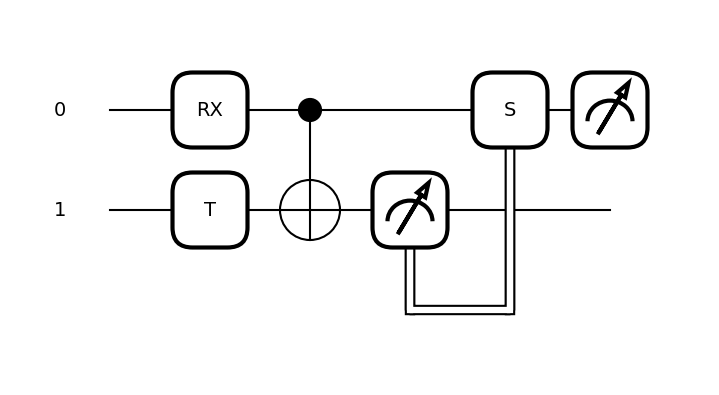

In [ ]:
fig, ax = qml.draw_mpl(circuit)(x)
